In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
%matplotlib inline

In [2]:
df = pd.read_csv(r'card_transdata.csv')

df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
# Conocer la roporción de la variable target
df.fraud.value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

Nuestra variable Target se denomina categorica, siendo (y=1) positivo para Fraude y (y=0) negativo para Fraude

1. Construimos matriz de feautres y vector Target

In [4]:
# Construimos la matriz de features donde tomamos todo el DataFrame en la eje X
X = df
X.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [5]:
# Construimos el vector target Y con la columna Fraud del DF
y = df.fraud
y.sample(10)

667150    0.0
909319    0.0
239014    0.0
271041    1.0
897796    0.0
561646    0.0
25131     0.0
979057    0.0
871818    0.0
591243    0.0
Name: fraud, dtype: float64

2. Diseñamos nuestro Train-Test-Split

In [6]:
# El argumento stratify nos permite generar una división que respeta la misma proporción entre clases en ambos sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12)

In [7]:
display(y_train.value_counts(normalize=True).round(2))
display(y_test.value_counts(normalize=True).round(2))

0.0    0.91
1.0    0.09
Name: fraud, dtype: float64

0.0    0.91
1.0    0.09
Name: fraud, dtype: float64

3. Clasificamos el DF con el modelo KNN

Inicialmente tomamos el hiperparametro por defecto, sin estandarizar la matriz

In [8]:
# Importamos la clase KNeighborsClassifier de módulo neighbors
from sklearn.neighbors import KNeighborsClassifier

In [9]:
# Instanciamos el modelo con su configuración por defecto
knn = KNeighborsClassifier()

In [10]:
# Ajustamos a los datos de entrenamiento
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [11]:
# Predecimos etiquetas para los datos de test
y_pred = knn.predict(X_test)

Entre los datos de pruebas y prediccion, vemos que se obtiene un 99% de Precision de conincidencia entre la muestra real y la prediccion

In [13]:
# Evaluamos el accuracy del modelo
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred).round(2)

0.99

In [20]:
recall_score(y_test, y_pred)

0.9617866459200952

Optimizamos el valor del hiperparametro K, haciendo una validacion cruzada tomando un rango de 0 a 10 para posterioirmente determinar el valor optimo de K

In [25]:
#optimizar el valor de K
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=5, shuffle=True, random_state=12)

scores_para_df = []

for i in tqdm(range(1,15)):
    y_pred = knn.predict(X_test)
    knn.fit(X_train, y_train)
    model = KNeighborsClassifier(n_neighbors=i)
    # cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
    # dict_row_score = {'score_medio':np.mean(cv_scores),
    #                  'score_std':np.std(cv_scores), 'n_neighbors':i}
    dict_row_score = {'recall': recall_score(y_test, y_pred), 'n_neighbors':i}
    # Guardamos cada uno en la lista de diccionarios
    scores_para_df.append(dict_row_score)

100%|██████████| 1/1 [00:14<00:00, 14.36s/it]


In [26]:
# Creamos el DataFrame a partir de la lista de diccionarios
df_scores = pd.DataFrame(scores_para_df)
df_scores.head(11)

,recall,n_neighbors
0,0.961787,1


In [24]:
# Generamos los límites inferior y superior
df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
df_scores.head()

,score_medio,score_std,n_neighbors,limite_inferior,limite_superior
0,0.993440,0.000146,1,0.993294,0.993586
1,0.992477,0.000129,2,0.992348,0.992606
2,0.992536,0.000123,3,0.992413,0.992659
3,0.992229,0.000277,4,0.991953,0.992506
4,0.992028,0.000235,5,0.991793,0.992263


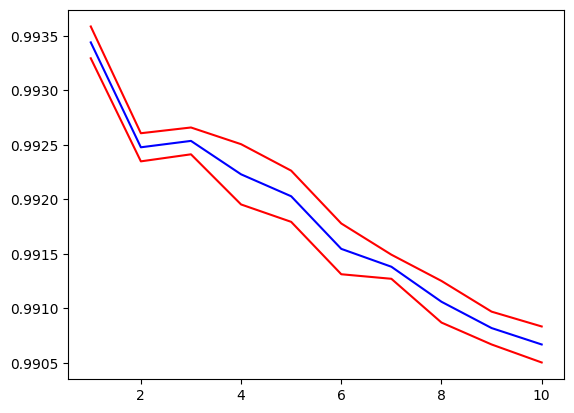

In [25]:
# Graficamos los resultados
plt.plot(df_scores['n_neighbors'], df_scores['limite_inferior'], color='r')
plt.plot(df_scores['n_neighbors'], df_scores['score_medio'], color='b')
plt.plot(df_scores['n_neighbors'], df_scores['limite_superior'], color='r');

Validamos cual es el valor que maximiza el score promedio, siendo en este caso el n_neighbors= 1

In [26]:
# Identificamos el score máximo
df_scores.loc[df_scores.score_medio == df_scores.score_medio.max()]

,score_medio,score_std,n_neighbors,limite_inferior,limite_superior
0,0.99344,0.000146,1,0.993294,0.993586


4. Iniciamos la estandarizacion de los datos de entranamiento para optener una mayor precision en la predicción, usando StandarScaler para optimizar  y homologar los valores de la Media(0) y Desvio(1) con el fin de tener un comportamiento correcto en el aprendizaje supervisado

In [27]:
#Estandarizacion Matriz
# Utilizamos sklearn para estandarizar la matriz de features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [28]:
# Verificamos que las variables ahora tengan media 0 y desvío 1.
print('Medias:', np.mean(X_train, axis=0).round(2))
print('Desvio:', np.std(X_train, axis=0).round(2))

Medias: [ 0. -0.  0.  0.  0. -0.  0.  0.]
Desvio: [1. 1. 1. 1. 1. 1. 1. 1.]


In [27]:
# Calculamos nuevamente los scores de cross validation,
# pero esta vez sobre los features estandarizados:

scores_para_df_standard = []

for i in tqdm(range(1, 2)):
    model = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
    dict_row_score = {'score_medio':np.mean(cv_scores),
                      'score_std':np.std(cv_scores), 'n_neighbors':i}
    scores_para_df_standard.append(dict_row_score)

  0%|          | 0/1 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [30]:
# Creamos el DataFrame a partir de la lista de diccionarios
df_scores_standard = pd.DataFrame(scores_para_df_standard)
df_scores_standard.head()

,score_medio,score_std,n_neighbors
0,0.999985,0.000005,1
1,0.999984,0.000007,2
2,0.999983,0.000009,3
3,0.999981,0.000005,4
4,0.999968,0.000010,5


In [31]:
# Armamos nuevamente los límites para graficar
df_scores_standard['limite_superior'] = df_scores_standard['score_medio'] + df_scores_standard['score_std']
df_scores_standard['limite_inferior'] = df_scores_standard['score_medio'] - df_scores_standard['score_std']
df_scores_standard.head()

,score_medio,score_std,n_neighbors,limite_superior,limite_inferior
0,0.999985,0.000005,1,0.999990,0.999980
1,0.999984,0.000007,2,0.999991,0.999977
2,0.999983,0.000009,3,0.999992,0.999974
3,0.999981,0.000005,4,0.999986,0.999976
4,0.999968,0.000010,5,0.999978,0.999958


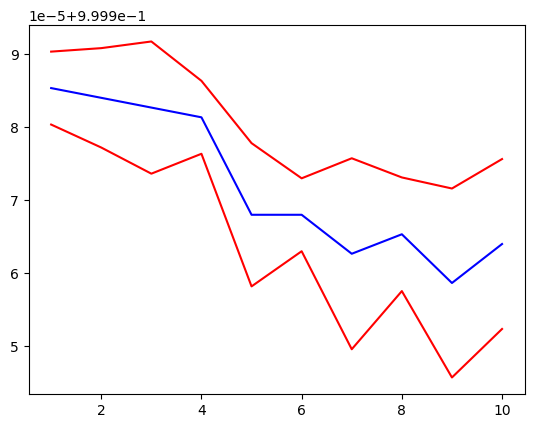

In [32]:
# Graficamos los resultados
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['limite_inferior'], color='r')
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['score_medio'], color='b')
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['limite_superior'], color='r');

Al hacer la identificacion del score maximo vemos que sigue siendo n_neighbors = 1, pero se puede observar que su performance cambia llevandolo cerca a 1 sus limites.

In [33]:
# Identificamos el score máximo
df_scores_standard.loc[df_scores_standard.score_medio == df_scores_standard.score_medio.max()]

,score_medio,score_std,n_neighbors,limite_superior,limite_inferior
0,0.999985,0.000005,1,0.99999,0.99998


Ahora obteniendo el valor optimo, conseguido en el paso anterioir, hacemos de nuevo el entramiento de los datos

In [34]:
# Asignamos el valor del k óptimo a una variable
best_k = df_scores_standard.loc[df_scores_standard.score_medio == df_scores_standard.score_medio.max(), 'n_neighbors'].values[0]
best_k

1

In [35]:
# Elegimos el modelo óptimo de acuerdo a las pruebas de cross validation
model = KNeighborsClassifier(n_neighbors=best_k)

# Lo ajustamos sobre los datos de entrenamiento
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

Obtenemos un ajuste en la precisión del entrenamiento de 100%

In [36]:
# Evaluamos qué accuracy obtenemos en train
accuracy_score(y_train, model.predict(X_train)).round(2)

1.0

In [37]:
# Lo utilizamos para predecir en test
X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)

Sin hacer el ajuste de estandarizacion a los datos de test, obtenemos tambien una presición del 100%

In [38]:
# Evaluamos el accuracy del modelo en test
accuracy_score(y_test, y_pred).round(2)

1.0

5. MATRIZ DE CONFUSION

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[228148,      1],
       [     2,  21849]], dtype=int64)

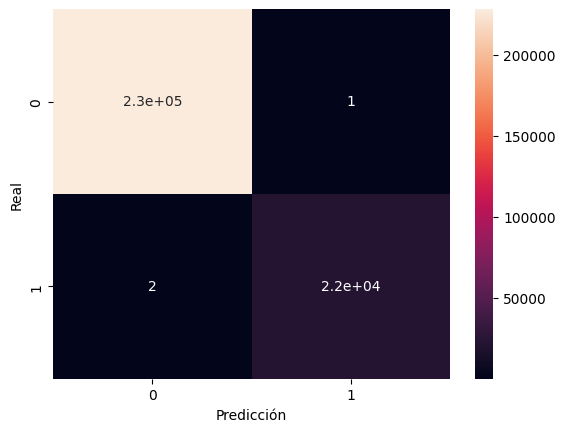

In [45]:
sns.heatmap(cm, annot=True)
plt.ylabel('Real')
plt.xlabel('Predicción');

* Casos negativos reales 230.000, correspondientes a la primera fila.

* Casos positivos reales 22.000, correspondientes a la segunda fila.

* Casos negativos predichos, corresponden a la primera columna.

* Casos positivos predichos, corresponden a la segunda columna.

* Diagonal en la matriz corresponde a las clasificaciones correctas. Siendo 230.000 casos negativos y 22.000 a casos positivos de Fraude.
Los Elementos de la diagonal inversa, nuestro modelo los confude siendo 1 caso mal etiquetado para negativo y 2 para positivo de fraude.

Finalmente calculamos la exactitud de nuestro modelo, de manera manual y computada, siendo ambas de precision del 100%

In [41]:
((cm[0,0] + cm[1,1]) / len(y_pred)).round(2)

1.0

In [42]:
accuracy_score(y_test, y_pred).round(2)

1.0